# MEDICAL TEXT CLASSIFICATION: LSTM WITH MULTIPLE EMBEDDINGS

## Objective
Multi-class medical symptom classification using LSTM with four different embedding approaches:
1. TF-IDF (Control)
2. Word2Vec (Skip-gram)
3. GloVe
4. FastText

## Key Dataset Decisions
- **Task**: Multi-class medical symptom classification
- **Input**: Tokenized clinical descriptions
- **Evaluation metrics**: Accuracy + Macro F1
- **Labels**: Integer-encoded for compatibility with cross-entropy loss

## IMPORTS AND SETUP

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [3]:
# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

True

## UTILITY FUNCTIONS

In [4]:
# Define custom medical stopwords
MEDICAL_STOPWORDS = set([
    'patient', 'symptoms', 'symptom', 'condition', 'medical', 'doctor', 
    'hospital', 'treatment', 'health', 'care', 'disease'
])

# Combine with standard English stopwords
STOP_WORDS = set(stopwords.words('english')).union(MEDICAL_STOPWORDS)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text, use_lemmatization=False):
    """
    Preprocess medical text:
    - Lowercase
    - Remove special characters
    - Remove stopwords
    - Optional lemmatization
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS and len(word) > 2]
    
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)


def build_vocab(text_series, max_vocab_size=5000):
    """
    Build vocabulary from text series.
    Returns a dictionary mapping words to indices.
    """
    # Count all words
    all_words = [word for text in text_series for word in text.split()]
    word_counts = Counter(all_words)
    
    # Keep only most common words
    most_common = word_counts.most_common(max_vocab_size - 2)
    
    # Create mapping
    vocab = {word: i+2 for i, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    
    return vocab


def text_to_sequence(text, vocab, max_len=50):
    """
    Convert text to fixed-length sequence of indices.
    """
    tokens = text.split()
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    
    if len(seq) > max_len:
        seq = seq[:max_len]
    else:
        seq = seq + [vocab['<PAD>']] * (max_len - len(seq))
    
    return seq


def text_to_sequence_with_length(text, vocab, max_len=50):
    """
    Convert text to sequence and return length (for packed sequences).
    """
    tokens = text.split()
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    length = min(len(seq), max_len)
    
    if len(seq) > max_len:
        seq = seq[:max_len]
    else:
        seq = seq + [vocab['<PAD>']] * (max_len - len(seq))
    
    return seq, length

In [5]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs, title_prefix=""):
    """
    Plot training and validation loss/accuracy curves.
    """
    plt.figure(figsize=(14, 6))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o', linewidth=2, markersize=6)
    plt.plot(epochs, val_losses, label='Val Loss', marker='o', linewidth=2, markersize=6)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'{title_prefix} Loss Curves', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(np.arange(1, len(train_losses) + 1, 2))
    
    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc', marker='o', linewidth=2, markersize=6)
    plt.plot(epochs, val_accs, label='Val Acc', marker='o', linewidth=2, markersize=6)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'{title_prefix} Accuracy Curves', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='lower right')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(np.arange(1, len(train_accs) + 1, 2))
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_labels, title="Confusion Matrix"):
    """
    Plot normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred).astype(float)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_norm, cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                annot=False, square=True, linewidths=0.5, linecolor='white')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    plt.show()


def print_metrics(y_true, y_pred, model_name="Model"):
    """
    Print accuracy, F1, precision, and recall.
    """
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    
    
    print(f"{model_name} Test Results")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
  
    
    return acc, f1, precision, recall

## LOAD AND PREPARE DATA

In [6]:
# Load dataset
df = pd.read_csv('medical_text.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (77175, 3)


,text,label,label_enc
0,the child started experiencing debilitating wh...,0,acne
1,the child suffers from moderate facial acne at...,0,acne
2,the patient has chronic skin breakout since ch...,0,acne
3,individual is having slight inflammatory acne ...,0,acne
4,he started experiencing slight zits for 3 weeks,0,acne


In [7]:
# Preprocess text
df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x, use_lemmatization=False))

# Encode labels
le = LabelEncoder()
y_labels = le.fit_transform(df['label_enc'])
num_classes = len(le.classes_)

print(f"Number of classes: {num_classes}")
print(f"\nClass distribution (first 10):")
print(pd.Series(y_labels).value_counts().head(10))

Number of classes: 105

Class distribution (first 10):
0     735
6     735
11    735
12    735
22    735
29    735
31    735
35    735
36    735
40    735
Name: count, dtype: int64


In [8]:
# Build vocabulary
vocab = build_vocab(df['clean_text'], max_vocab_size=5000)
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 640


In [9]:
# Global hyperparameter
num_epochs = 20

## DATASET EXPLORATION AND ANALYSIS

Before building the models, the dataset is explored to understand:
1. **Class Balance**: Distribution of medical conditions
2. **Text Length**: Word count distribution to inform max_len choice
3. **Top Keywords**: Most important medical terms via TF-IDF
4. **Vocabulary Size**: Coverage analysis

In [10]:
# Set visualization style
sns.set(style="whitegrid")

C:\Users\fadhl\AppData\Local\Temp\ipykernel_7836\1671786866.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis')


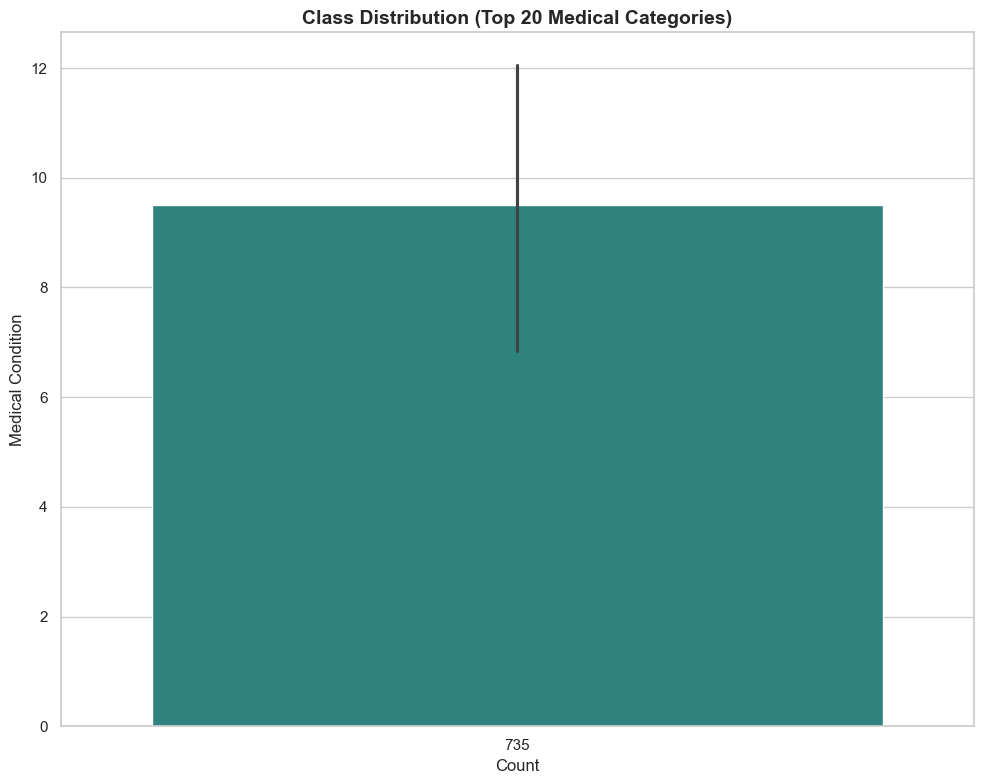

Total classes: 105
Most common class: acne (735 samples)
Least common class: wrist pain (735 samples)
Balance ratio (max/min): 1.00:1
Mean samples per class: 735.0
Median samples per class: 735.0


In [11]:
# Plot 1: Class Balance (Top 20 Medical Categories)
plt.figure(figsize=(10, 8))

# Get class distribution
if 'label' in df.columns:
    top_classes = df['label'].value_counts().head(20)
else:
    label_counts = pd.Series(y_labels).value_counts().head(20)
    top_classes = pd.Series(
        label_counts.values,
        index=[le.classes_[i] for i in label_counts.index]
    )

sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis')
plt.title('Class Distribution (Top 20 Medical Categories)', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Medical Condition', fontsize=12)
plt.tight_layout()
#plt.savefig('class_balance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
all_counts = pd.Series(y_labels).value_counts()
print(f"Total classes: {num_classes}")
print(f"Most common class: {le.classes_[all_counts.index[0]]} ({all_counts.values[0]} samples)")
print(f"Least common class: {le.classes_[all_counts.index[-1]]} ({all_counts.values[-1]} samples)")
print(f"Balance ratio (max/min): {all_counts.values[0] / all_counts.values[-1]:.2f}:1")
print(f"Mean samples per class: {all_counts.mean():.1f}")
print(f"Median samples per class: {all_counts.median():.1f}")

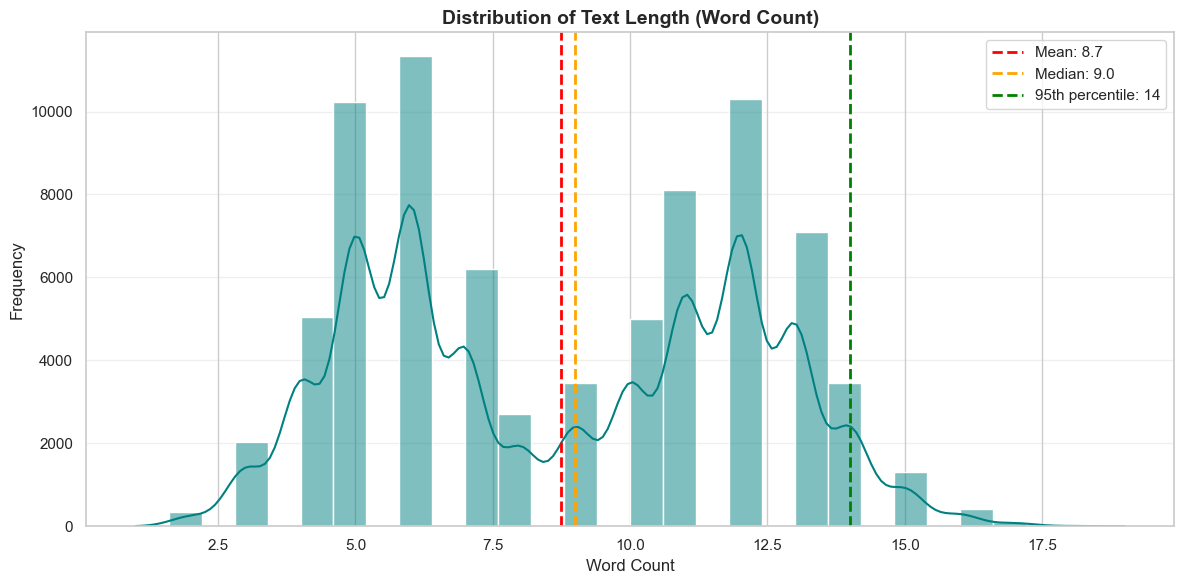

Text Length Statistics:
  Mean: 8.74 words
  Median: 9.00 words
  Min: 1 words
  Max: 19 words
  95th percentile: 14 words
  99th percentile: 15 words


In [12]:
# Plot 2: Text Length Distribution (Word Count)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=30, kde=True, color='teal')
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["word_count"].mean():.1f}')
plt.axvline(df['word_count'].median(), color='orange', linestyle='--', 
            linewidth=2, label=f'Median: {df["word_count"].median():.1f}')
plt.axvline(df['word_count'].quantile(0.95), color='green', linestyle='--', 
            linewidth=2, label=f'95th percentile: {df["word_count"].quantile(0.95):.0f}')

plt.title('Distribution of Text Length (Word Count)', fontsize=14, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
# plt.savefig('text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"Text Length Statistics:")
print(f"  Mean: {df['word_count'].mean():.2f} words")
print(f"  Median: {df['word_count'].median():.2f} words")
print(f"  Min: {df['word_count'].min()} words")
print(f"  Max: {df['word_count'].max()} words")
print(f"  95th percentile: {df['word_count'].quantile(0.95):.0f} words")
print(f"  99th percentile: {df['word_count'].quantile(0.99):.0f} words")


C:\Users\fadhl\AppData\Local\Temp\ipykernel_7836\2271686539.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(words), palette='magma')


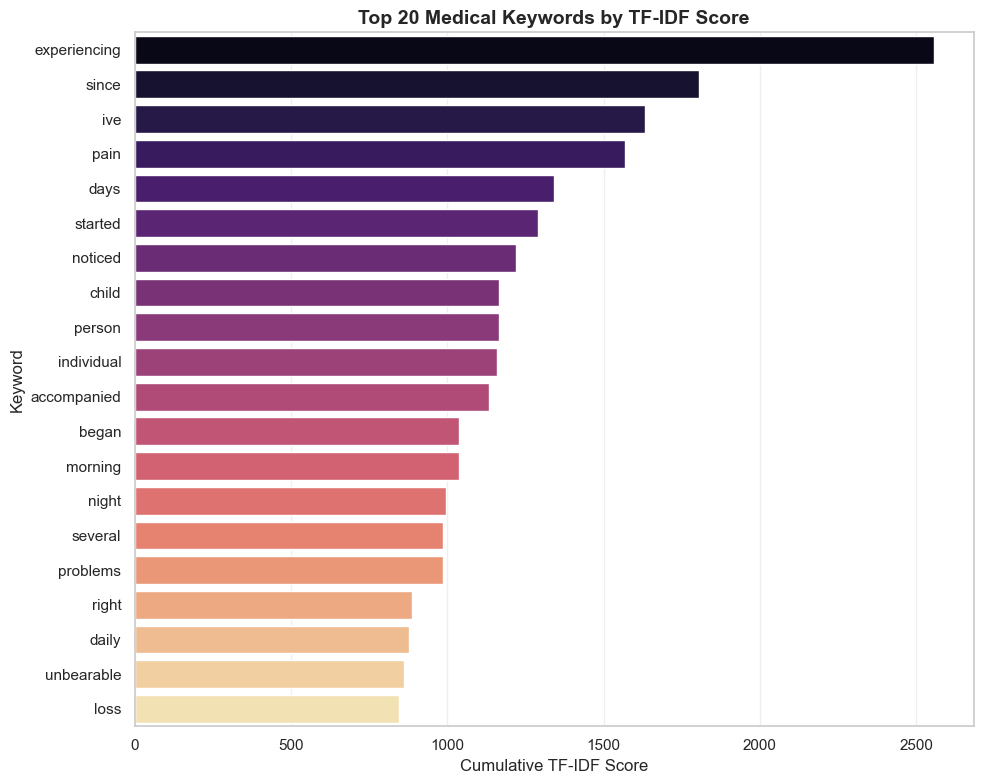

In [13]:
# Plot 3: Top 20 Keywords via TF-IDF
X_train_raw_viz, _ = train_test_split(
    df['clean_text'], test_size=0.3, random_state=42
)

# Compute TF-IDF
tfidf_viz = TfidfVectorizer(max_features=5000)
X_train_tfidf_viz = tfidf_viz.fit_transform(X_train_raw_viz)

# Get cumulative TF-IDF scores
sum_tfidf = X_train_tfidf_viz.sum(axis=0)
words_freq = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_viz.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]
words, scores = zip(*words_freq)

plt.figure(figsize=(10, 8))
sns.barplot(x=list(scores), y=list(words), palette='magma')
plt.title('Top 20 Medical Keywords by TF-IDF Score', fontsize=14, fontweight='bold')
plt.xlabel('Cumulative TF-IDF Score', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
# plt.savefig('top_keywords_tfidf.png', dpi=300, bbox_inches='tight')
plt.show()


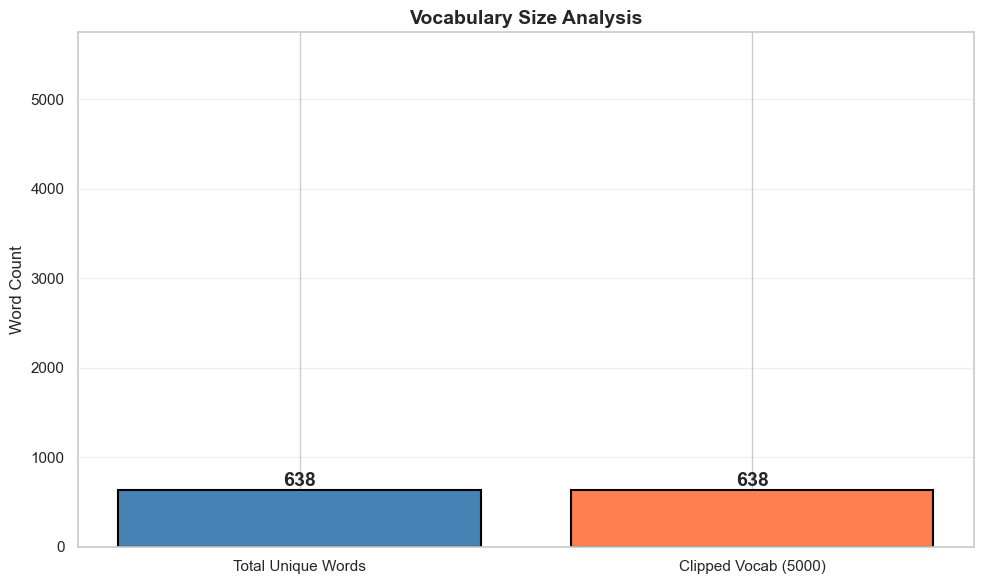

In [14]:
# Plot 4: Vocabulary Size Analysis
all_tokens_raw = [word for text in df['clean_text'] for word in text.split()]
total_unique = len(set(all_tokens_raw))
max_vocab = 5000

plt.figure(figsize=(10, 6))
bars = plt.bar(
    ['Total Unique Words', f'Clipped Vocab ({max_vocab})'], 
    [total_unique, min(total_unique, max_vocab)], 
    color=['steelblue', 'coral'],
    edgecolor='black',
    linewidth=1.5
)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title('Vocabulary Size Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Word Count', fontsize=12)
plt.ylim(0, max(total_unique, max_vocab) * 1.15)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
#plt.savefig('vocab_size_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



# EXPERIMENT 1: TF-IDF

**Purpose**: Baseline. TF-IDF ignores word order and subword structure.

**Architecture**: Simple feedforward network

**Hyperparameters**:
- TF-IDF max features: 5000
- Hidden dim: 128
- Dropout: 0.3
- Batch size: 32
- Epochs: 20
- Learning rate: 0.001

In [15]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray().astype(np.float32)

print(f"TF-IDF feature shape: {X_tfidf.shape}")
print(f"Actual vocabulary size: {X_tfidf.shape[1]}")

TF-IDF feature shape: (77175, 638)
Actual vocabulary size: 638


In [16]:
# Train-validation-test split
X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(
    X_tfidf, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(
    X_temp_tfidf, y_temp_tfidf, test_size=0.5, random_state=42, stratify=y_temp_tfidf
)

print(f"Train size: {X_train_tfidf.shape[0]}")
print(f"Val size: {X_val_tfidf.shape[0]}")
print(f"Test size: {X_test_tfidf.shape[0]}")

Train size: 54022
Val size: 11576
Test size: 11577


In [17]:
# Create DataLoaders
train_dataset_tfidf = TensorDataset(
    torch.FloatTensor(X_train_tfidf),
    torch.LongTensor(y_train_tfidf)
)
val_dataset_tfidf = TensorDataset(
    torch.FloatTensor(X_val_tfidf),
    torch.LongTensor(y_val_tfidf)
)
test_dataset_tfidf = TensorDataset(
    torch.FloatTensor(X_test_tfidf),
    torch.LongTensor(y_test_tfidf)
)

batch_size_tfidf = 32
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size_tfidf, shuffle=True)
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size_tfidf)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=batch_size_tfidf)

In [18]:
# TF-IDF Model
class TFIDFClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TFIDFClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model_tfidf = TFIDFClassifier(input_dim=X_tfidf.shape[1], output_dim=num_classes)
print(model_tfidf)

TFIDFClassifier(
  (fc1): Linear(in_features=638, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=105, bias=True)
)


In [19]:
# Training setup
criterion_tfidf = nn.CrossEntropyLoss()
optimizer_tfidf = torch.optim.Adam(model_tfidf.parameters(), lr=0.001)

train_losses_tfidf = []
val_losses_tfidf = []
train_accs_tfidf = []
val_accs_tfidf = []

In [20]:
# Training loop
print("Training TF-IDF model...\n")

for epoch in range(num_epochs):
    # Training
    model_tfidf.train()
    train_loss, train_correct, total_train = 0, 0, 0
    
    for X_batch, y_batch in train_loader_tfidf:
        optimizer_tfidf.zero_grad()
        outputs = model_tfidf(X_batch)
        loss = criterion_tfidf(outputs, y_batch)
        loss.backward()
        optimizer_tfidf.step()
        
        train_loss += loss.item() * X_batch.size(0)
        train_correct += (outputs.argmax(1) == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    train_loss /= total_train
    train_acc = train_correct / total_train
    train_losses_tfidf.append(train_loss)
    train_accs_tfidf.append(train_acc)
    
    # Validation
    model_tfidf.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader_tfidf:
            outputs = model_tfidf(X_batch)
            loss = criterion_tfidf(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()
            total_val += y_batch.size(0)
    
    val_loss /= total_val
    val_acc = val_correct / total_val
    val_losses_tfidf.append(val_loss)
    val_accs_tfidf.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Training TF-IDF model...

Epoch [1/20] Train Loss: 1.5773, Train Acc: 0.8218 | Val Loss: 0.1317, Val Acc: 0.9784
Epoch [2/20] Train Loss: 0.0952, Train Acc: 0.9821 | Val Loss: 0.0449, Val Acc: 0.9857
Epoch [3/20] Train Loss: 0.0454, Train Acc: 0.9856 | Val Loss: 0.0309, Val Acc: 0.9865
Epoch [4/20] Train Loss: 0.0313, Train Acc: 0.9874 | Val Loss: 0.0269, Val Acc: 0.9856
Epoch [5/20] Train Loss: 0.0257, Train Acc: 0.9881 | Val Loss: 0.0253, Val Acc: 0.9864
Epoch [6/20] Train Loss: 0.0219, Train Acc: 0.9897 | Val Loss: 0.0267, Val Acc: 0.9852
Epoch [7/20] Train Loss: 0.0197, Train Acc: 0.9911 | Val Loss: 0.0267, Val Acc: 0.9861
Epoch [8/20] Train Loss: 0.0178, Train Acc: 0.9916 | Val Loss: 0.0275, Val Acc: 0.9845
Epoch [9/20] Train Loss: 0.0167, Train Acc: 0.9920 | Val Loss: 0.0271, Val Acc: 0.9857
Epoch [10/20] Train Loss: 0.0152, Train Acc: 0.9930 | Val Loss: 0.0284, Val Acc: 0.9852
Epoch [11/20] Train Loss: 0.0141, Train Acc: 0.9940 | Val Loss: 0.0288, Val Acc: 0.9852
Epoch [12/20] T

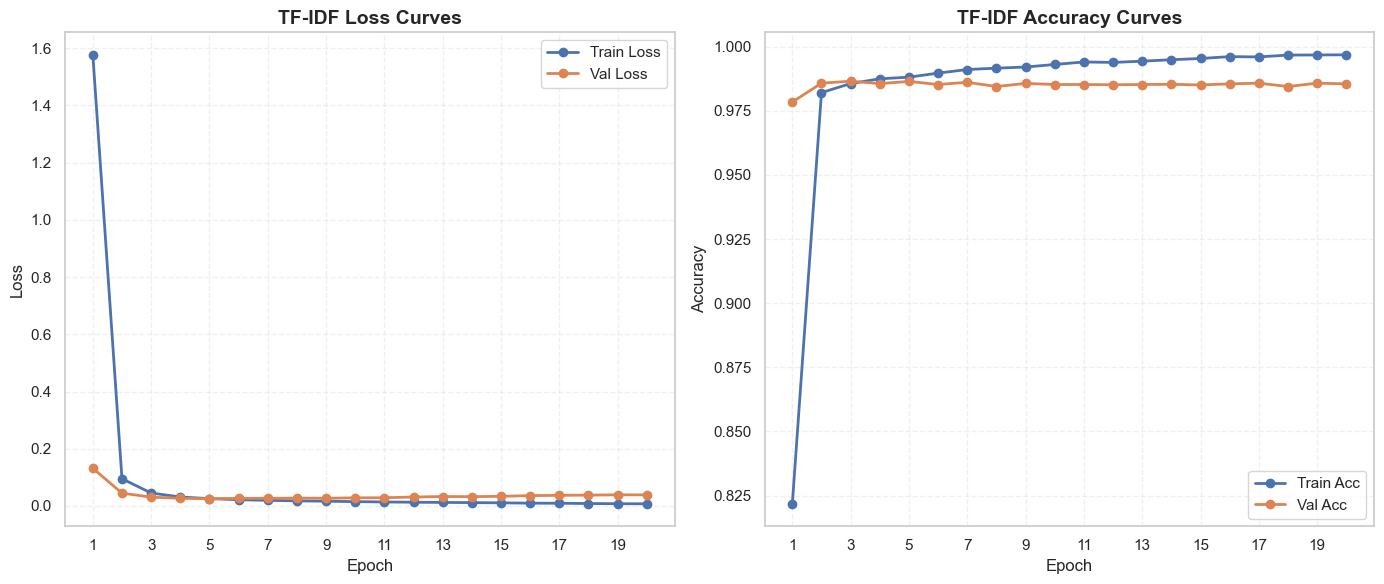

In [21]:
# Plot learning curves
plot_learning_curves(train_losses_tfidf, val_losses_tfidf, train_accs_tfidf, val_accs_tfidf, "TF-IDF")

In [22]:
# Evaluate on test set
model_tfidf.eval()
y_true_tfidf, y_pred_tfidf = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_tfidf:
        outputs = model_tfidf(X_batch)
        preds = outputs.argmax(1)
        y_true_tfidf.extend(y_batch.numpy())
        y_pred_tfidf.extend(preds.numpy())

y_true_tfidf = np.array(y_true_tfidf)
y_pred_tfidf = np.array(y_pred_tfidf)

acc_tfidf, f1_tfidf, prec_tfidf, rec_tfidf = print_metrics(y_true_tfidf, y_pred_tfidf, "TF-IDF")

TF-IDF Test Results
Accuracy: 0.9850
F1 Score: 0.9850
Precision: 0.9850
Recall: 0.9850


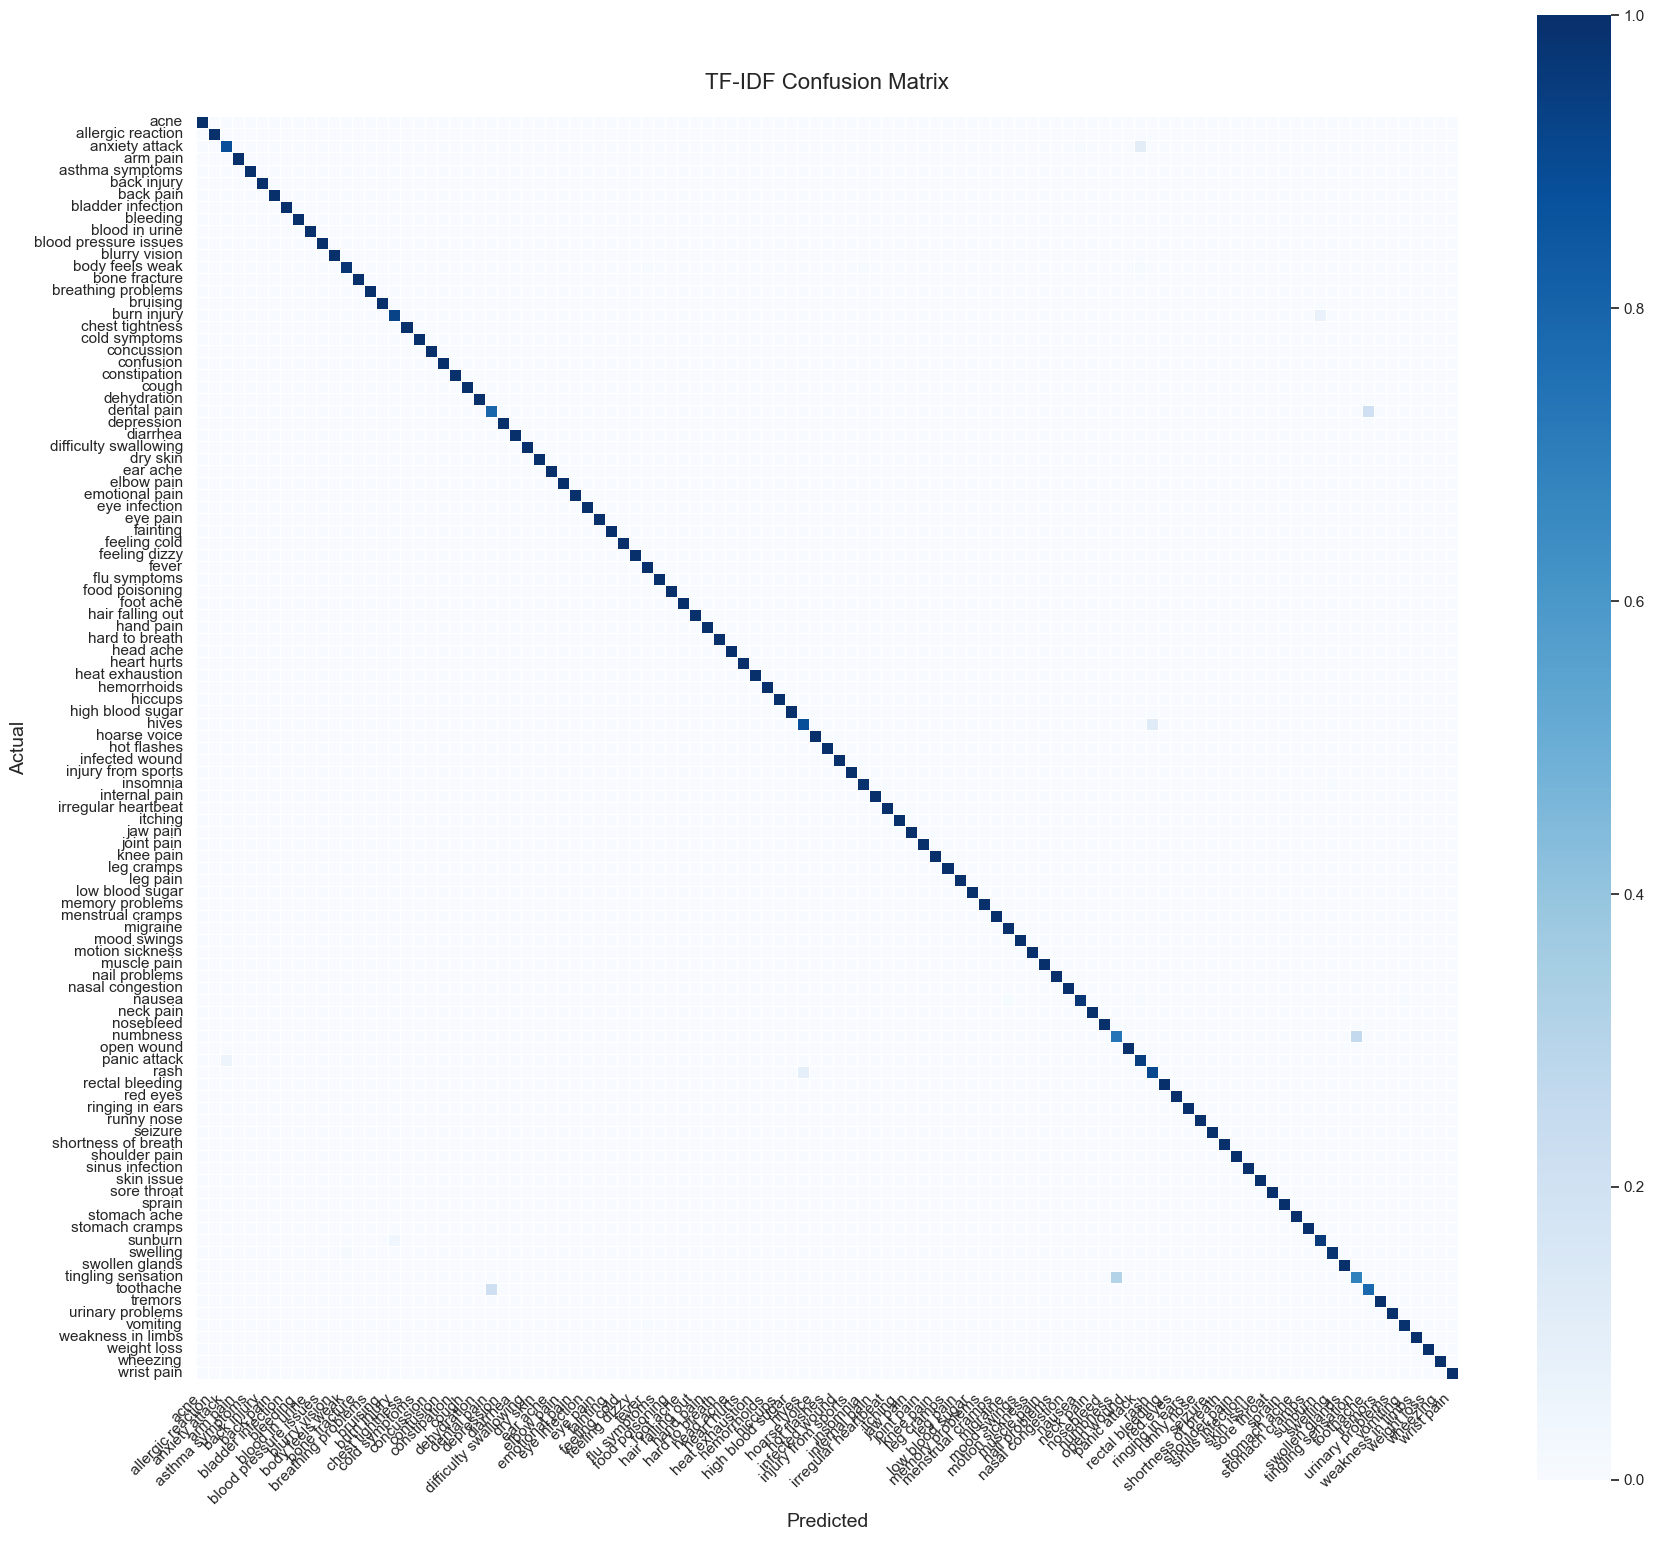

In [23]:
# Plot confusion matrix
plot_confusion_matrix(y_true_tfidf, y_pred_tfidf, le.classes_, "TF-IDF Confusion Matrix")

# EXPERIMENT 2: Word2Vec + LSTM

**Purpose**: Learn domain-specific embeddings from medical text.

**Key Points**:
- Trained on training text only (prevents leakage)
- Skip-gram architecture
- Smaller model suited for domain vocabulary

**Hyperparameters**:
- Embedding dim: 100
- Hidden dim: 64  
- Dropout: 0.2
- Batch size: 16 
- Max length: 20  
- Learning rate: 0.002
- Epochs: 20
- Window: 5
- Min count: 1

In [24]:
# Word2Vec specific hyperparameters
embedding_dim_w2v = 100
hidden_dim_w2v = 64
dropout_w2v = 0.2
batch_size_w2v = 16
max_len_w2v = 20
learning_rate_w2v = 0.002

In [25]:
# Prepare training texts for Word2Vec (truncated to max_len)
X_train_texts_w2v = [text.split()[:max_len_w2v] for text in df['clean_text']]

print(f"Training Word2Vec on {len(X_train_texts_w2v)} samples")

Training Word2Vec on 77175 samples


In [26]:
# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=X_train_texts_w2v,
    vector_size=embedding_dim_w2v,
    window=5,
    min_count=1,
    sg=1,
    workers=4,
    seed=42
)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")

Word2Vec vocabulary size: 638


In [27]:
# Build embedding matrix
embedding_matrix_w2v = np.zeros((vocab_size, embedding_dim_w2v))

for word, idx in vocab.items():
    if word in w2v_model.wv:
        embedding_matrix_w2v[idx] = w2v_model.wv[word]
    else:
        embedding_matrix_w2v[idx] = np.random.normal(scale=0.6, size=(embedding_dim_w2v,))

print(f"Embedding matrix shape: {embedding_matrix_w2v.shape}")

Embedding matrix shape: (640, 100)


In [28]:
# Word2Vec LSTM Model (Original Architecture)
class LSTMClassifier_W2V(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        return self.fc(x)

model_w2v = LSTMClassifier_W2V(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_w2v,
    embedding_matrix=embedding_matrix_w2v,
    hidden_dim=hidden_dim_w2v,
    output_dim=num_classes,
    dropout=dropout_w2v
)

print(model_w2v)

LSTMClassifier_W2V(
  (embedding): Embedding(640, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=105, bias=True)
)


In [29]:
# Prepare sequences
X_sequences_w2v = torch.tensor(
    [text_to_sequence(text, vocab, max_len_w2v) for text in df['clean_text']], 
    dtype=torch.long
)
y_tensor_w2v = torch.tensor(y_labels, dtype=torch.long)

print(f"Sequence shape: {X_sequences_w2v.shape}")

Sequence shape: torch.Size([77175, 20])


In [30]:
# Train-val-test split
train_size = int(0.7 * len(X_sequences_w2v))
val_size = int(0.15 * len(X_sequences_w2v))
test_size = len(X_sequences_w2v) - train_size - val_size

train_dataset_w2v, val_dataset_w2v, test_dataset_w2v = torch.utils.data.random_split(
    TensorDataset(X_sequences_w2v, y_tensor_w2v),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train size: {len(train_dataset_w2v)}")
print(f"Val size: {len(val_dataset_w2v)}")
print(f"Test size: {len(test_dataset_w2v)}")

Train size: 54022
Val size: 11576
Test size: 11577


In [31]:
# Create DataLoaders
train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=batch_size_w2v, shuffle=True)
val_loader_w2v = DataLoader(val_dataset_w2v, batch_size=batch_size_w2v)
test_loader_w2v = DataLoader(test_dataset_w2v, batch_size=batch_size_w2v)

In [32]:
# Training setup
criterion_w2v = nn.CrossEntropyLoss()
optimizer_w2v = torch.optim.Adam(model_w2v.parameters(), lr=learning_rate_w2v)

train_losses_w2v = []
val_losses_w2v = []
train_accs_w2v = []
val_accs_w2v = []

In [33]:
# Training loop
print("Training Word2Vec LSTM model...\n")

for epoch in range(num_epochs):
    # Training
    model_w2v.train()
    train_loss, train_correct, total_train = 0, 0, 0
    
    for X_batch, y_batch in train_loader_w2v:
        optimizer_w2v.zero_grad()
        outputs = model_w2v(X_batch)
        loss = criterion_w2v(outputs, y_batch)
        loss.backward()
        optimizer_w2v.step()
        
        train_loss += loss.item() * X_batch.size(0)
        train_correct += (outputs.argmax(1) == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    train_loss /= total_train
    train_acc = train_correct / total_train
    train_losses_w2v.append(train_loss)
    train_accs_w2v.append(train_acc)
    
    # Validation
    model_w2v.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader_w2v:
            outputs = model_w2v(X_batch)
            loss = criterion_w2v(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()
            total_val += y_batch.size(0)
    
    val_loss /= total_val
    val_acc = val_correct / total_val
    val_losses_w2v.append(val_loss)
    val_accs_w2v.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Training Word2Vec LSTM model...

Epoch [1/20] Train Loss: 4.6568, Train Acc: 0.0095 | Val Loss: 4.6558, Val Acc: 0.0082
Epoch [2/20] Train Loss: 4.6556, Train Acc: 0.0091 | Val Loss: 4.6560, Val Acc: 0.0078
Epoch [3/20] Train Loss: 4.6557, Train Acc: 0.0093 | Val Loss: 4.6555, Val Acc: 0.0081
Epoch [4/20] Train Loss: 4.6556, Train Acc: 0.0094 | Val Loss: 4.6557, Val Acc: 0.0098
Epoch [5/20] Train Loss: 4.6556, Train Acc: 0.0096 | Val Loss: 4.6559, Val Acc: 0.0078
Epoch [6/20] Train Loss: 4.6556, Train Acc: 0.0097 | Val Loss: 4.6557, Val Acc: 0.0088
Epoch [7/20] Train Loss: 3.9732, Train Acc: 0.1282 | Val Loss: 0.4916, Val Acc: 0.9181
Epoch [8/20] Train Loss: 0.1066, Train Acc: 0.9762 | Val Loss: 0.0262, Val Acc: 0.9853
Epoch [9/20] Train Loss: 0.0340, Train Acc: 0.9853 | Val Loss: 0.0262, Val Acc: 0.9857
Epoch [10/20] Train Loss: 0.0305, Train Acc: 0.9858 | Val Loss: 0.0245, Val Acc: 0.9855
Epoch [11/20] Train Loss: 0.0266, Train Acc: 0.9861 | Val Loss: 0.0230, Val Acc: 0.9864
Epoch [1

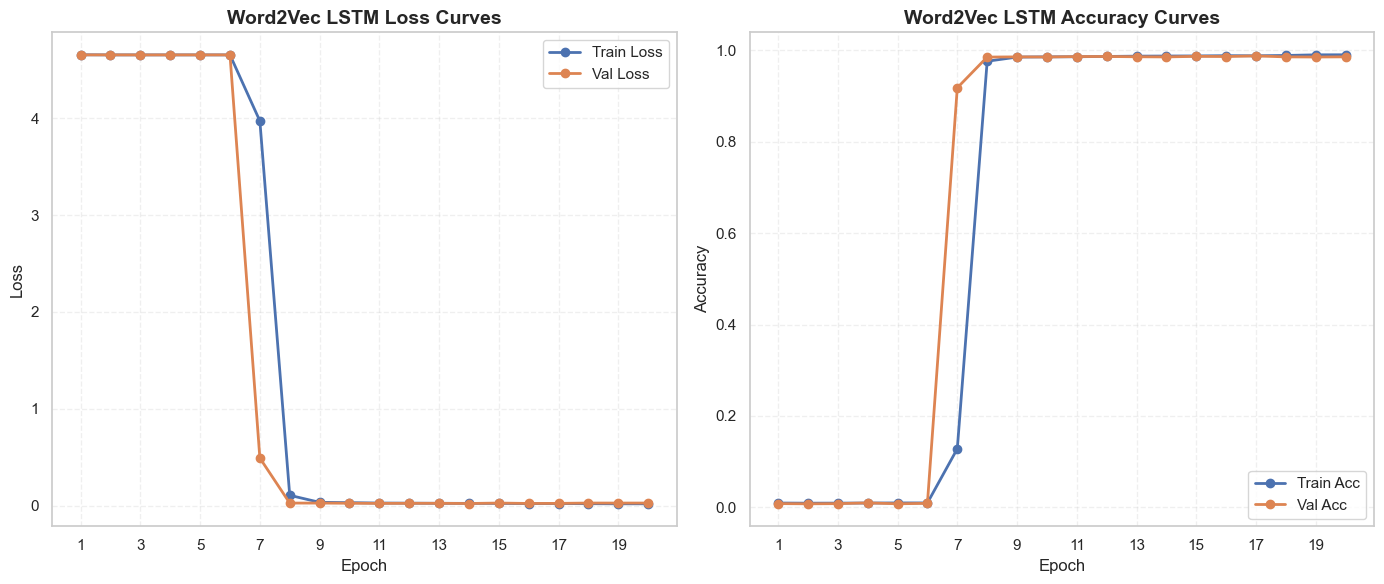

In [34]:
# Plot learning curves
plot_learning_curves(train_losses_w2v, val_losses_w2v, train_accs_w2v, val_accs_w2v, "Word2Vec LSTM")

In [35]:
# Evaluate on test set
model_w2v.eval()
y_true_w2v, y_pred_w2v = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_w2v:
        outputs = model_w2v(X_batch)
        preds = outputs.argmax(1)
        y_true_w2v.extend(y_batch.numpy())
        y_pred_w2v.extend(preds.numpy())

y_true_w2v = np.array(y_true_w2v)
y_pred_w2v = np.array(y_pred_w2v)

acc_w2v, f1_w2v, prec_w2v, rec_w2v = print_metrics(y_true_w2v, y_pred_w2v, "Word2Vec LSTM")

Word2Vec LSTM Test Results
Accuracy: 0.9857
F1 Score: 0.9865
Precision: 0.9868
Recall: 0.9866


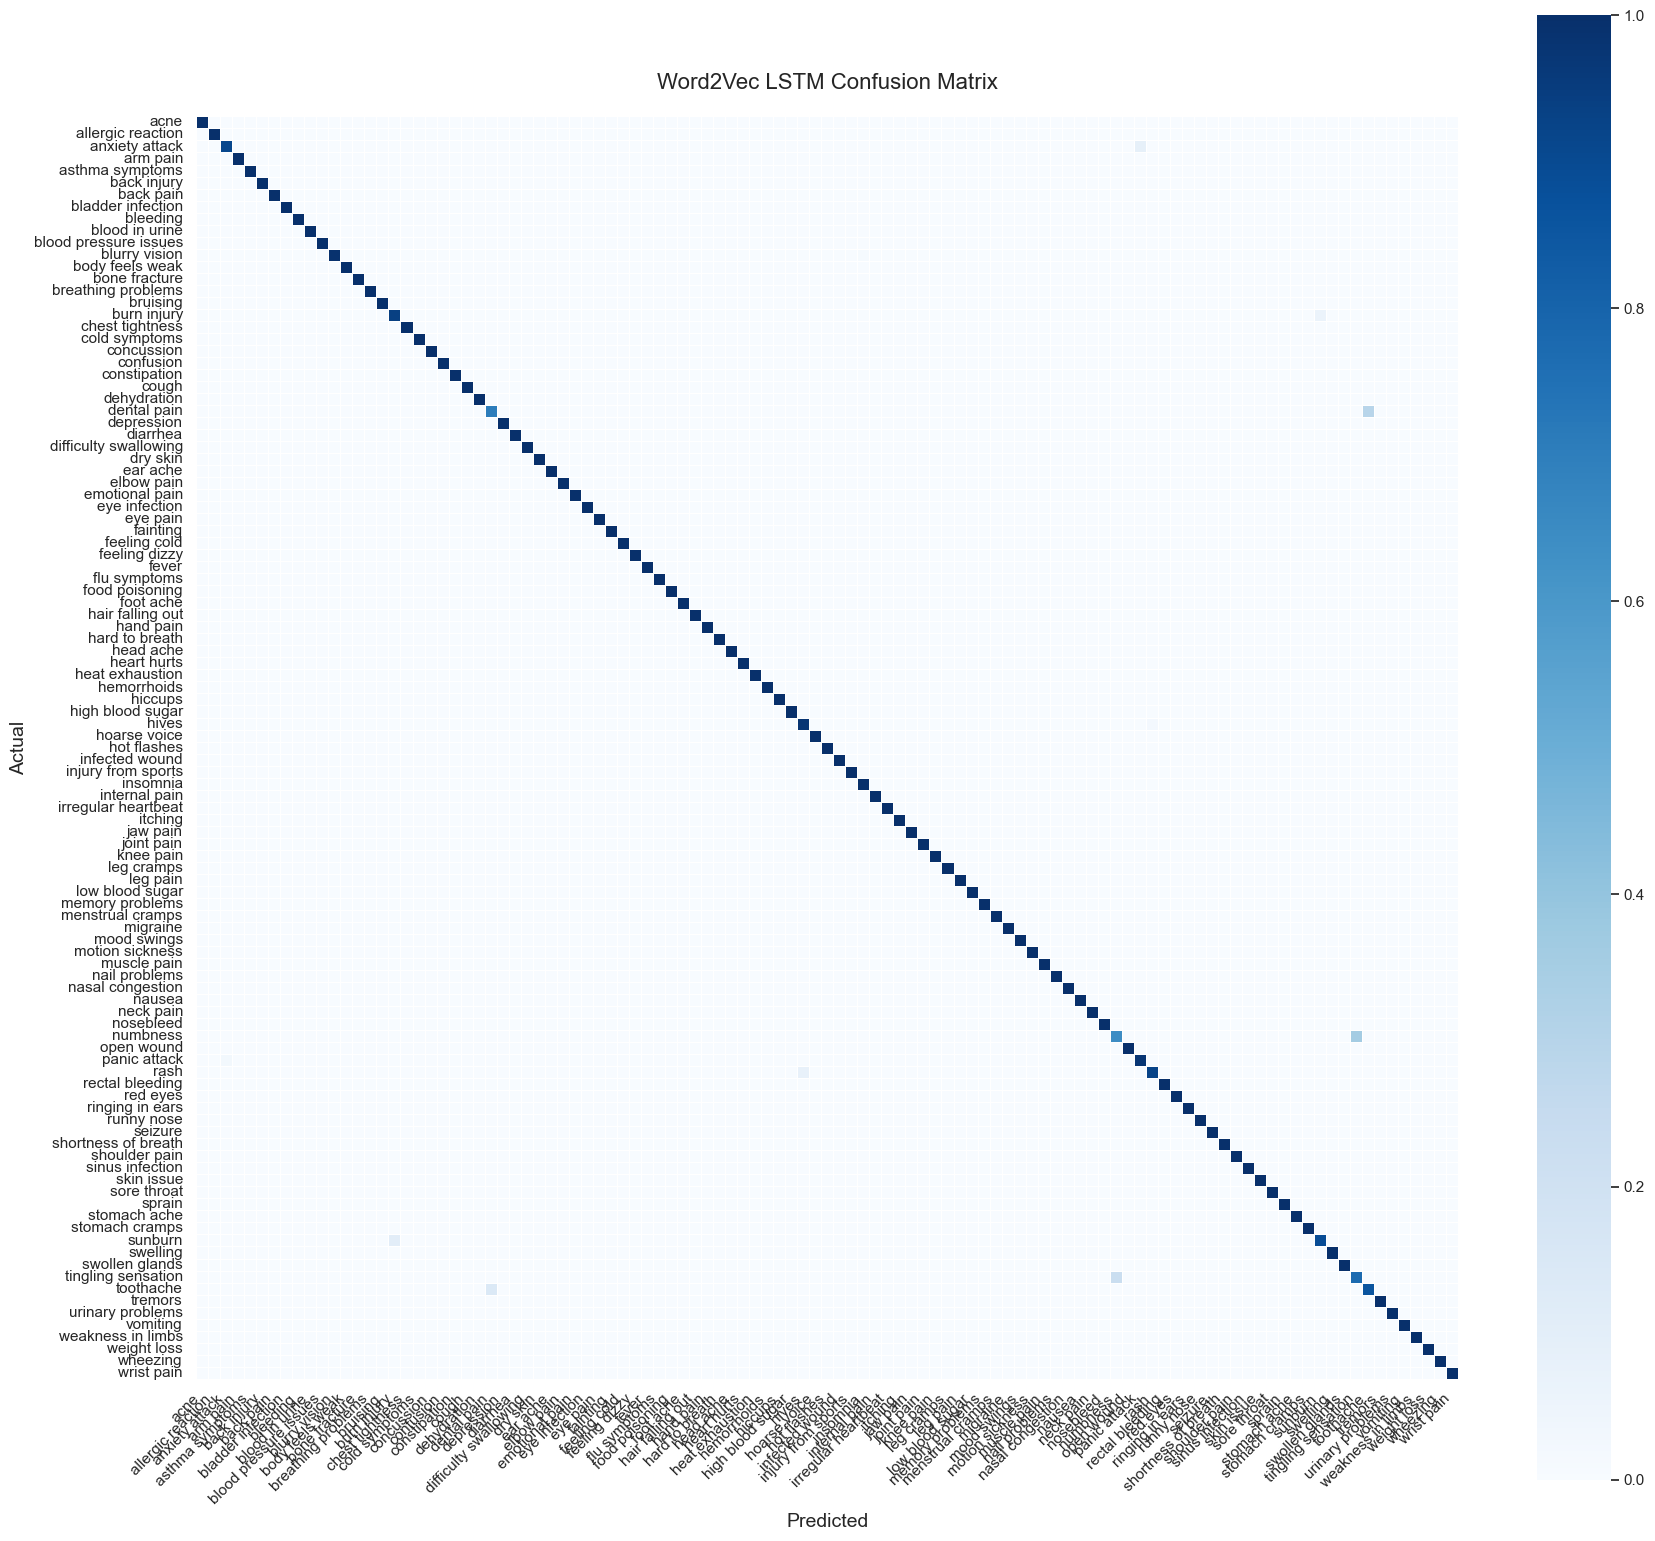

In [36]:
# Plot confusion matrix
plot_confusion_matrix(y_true_w2v, y_pred_w2v, le.classes_, "Word2Vec LSTM Confusion Matrix")

# EXPERIMENT 3: GloVe + LSTM

**Purpose**: Use pre-trained embeddings from general corpus.

**Key Points**:
- Pre-trained on Wikipedia + news
- Domain mismatch expected
- Uses packed sequences for efficiency

**Hyperparameters**:
- Embedding dim: 100 (glove.6B.100d)
- Hidden dim: 128
- Batch size: 32
- Max length: 50
- Learning rate: 0.001
- Epochs: 20
- **Uses pack_padded_sequence**

In [37]:
embedding_dim_glove = 100
hidden_dim_glove = 128
batch_size_glove = 32
max_len_glove = 50
learning_rate_glove = 0.001


In [38]:
# Load GloVe embeddings
glove_path = "glove.6B.100d.txt"
glove_embeddings = {}

with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

print(f"Loaded {len(glove_embeddings)} word vectors")

Loaded 400000 word vectors


In [39]:
# Build embedding matrix
embedding_matrix_glove = np.zeros((vocab_size, embedding_dim_glove))
hits, misses = 0, 0

for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix_glove[idx] = glove_embeddings[word]
        hits += 1
    else:
        embedding_matrix_glove[idx] = np.random.normal(scale=0.6, size=(embedding_dim_glove,))
        misses += 1

print(f"\nEmbedding matrix: {embedding_matrix_glove.shape}")


Embedding matrix: (640, 100)


In [40]:
# Prepare data with lengths for GloVe
# Split first
X_train_text, X_temp_text, y_train_glove, y_temp_glove = train_test_split(
    df['clean_text'].values, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)
X_val_text, X_test_text, y_val_glove, y_test_glove = train_test_split(
    X_temp_text, y_temp_glove, test_size=0.5, random_state=42, stratify=y_temp_glove
)

# Convert to sequences with lengths
X_train_seq_glove, train_lengths_glove = zip(*[text_to_sequence_with_length(t, vocab, max_len_glove) for t in X_train_text])
X_val_seq_glove, val_lengths_glove = zip(*[text_to_sequence_with_length(t, vocab, max_len_glove) for t in X_val_text])
X_test_seq_glove, test_lengths_glove = zip(*[text_to_sequence_with_length(t, vocab, max_len_glove) for t in X_test_text])

# Convert to tensors
X_train_seq_glove = torch.tensor(X_train_seq_glove, dtype=torch.long)
X_val_seq_glove = torch.tensor(X_val_seq_glove, dtype=torch.long)
X_test_seq_glove = torch.tensor(X_test_seq_glove, dtype=torch.long)

train_lengths_glove = torch.tensor(train_lengths_glove)
val_lengths_glove = torch.tensor(val_lengths_glove)
test_lengths_glove = torch.tensor(test_lengths_glove)

In [41]:
# Custom collate function for packed sequences
def collate_fn_glove(batch):
    sequences, lengths, labels = zip(*batch)
    sequences = torch.stack(sequences)
    lengths = torch.stack(lengths)
    labels = torch.stack(labels)
    return sequences, lengths, labels

# Create datasets
train_dataset_glove = TensorDataset(X_train_seq_glove, train_lengths_glove, torch.LongTensor(y_train_glove))
val_dataset_glove = TensorDataset(X_val_seq_glove, val_lengths_glove, torch.LongTensor(y_val_glove))
test_dataset_glove = TensorDataset(X_test_seq_glove, test_lengths_glove, torch.LongTensor(y_test_glove))

# Create DataLoaders
train_loader_glove = DataLoader(train_dataset_glove, batch_size=batch_size_glove, shuffle=True, collate_fn=collate_fn_glove)
val_loader_glove = DataLoader(val_dataset_glove, batch_size=batch_size_glove, collate_fn=collate_fn_glove)
test_loader_glove = DataLoader(test_dataset_glove, batch_size=batch_size_glove, collate_fn=collate_fn_glove)

In [42]:
# GloVe LSTM Model (with packed sequences)
class LSTM_GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        out = self.fc(h_n[-1])
        return out

model_glove = LSTM_GloVe(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_glove,
    hidden_dim=hidden_dim_glove,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_glove
)

print(model_glove)

LSTM_GloVe(
  (embedding): Embedding(640, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=105, bias=True)
)


In [43]:
# Training setup
criterion_glove = nn.CrossEntropyLoss()
optimizer_glove = optim.Adam(model_glove.parameters(), lr=learning_rate_glove)

train_losses_glove = []
val_losses_glove = []
train_accs_glove = []
val_accs_glove = []

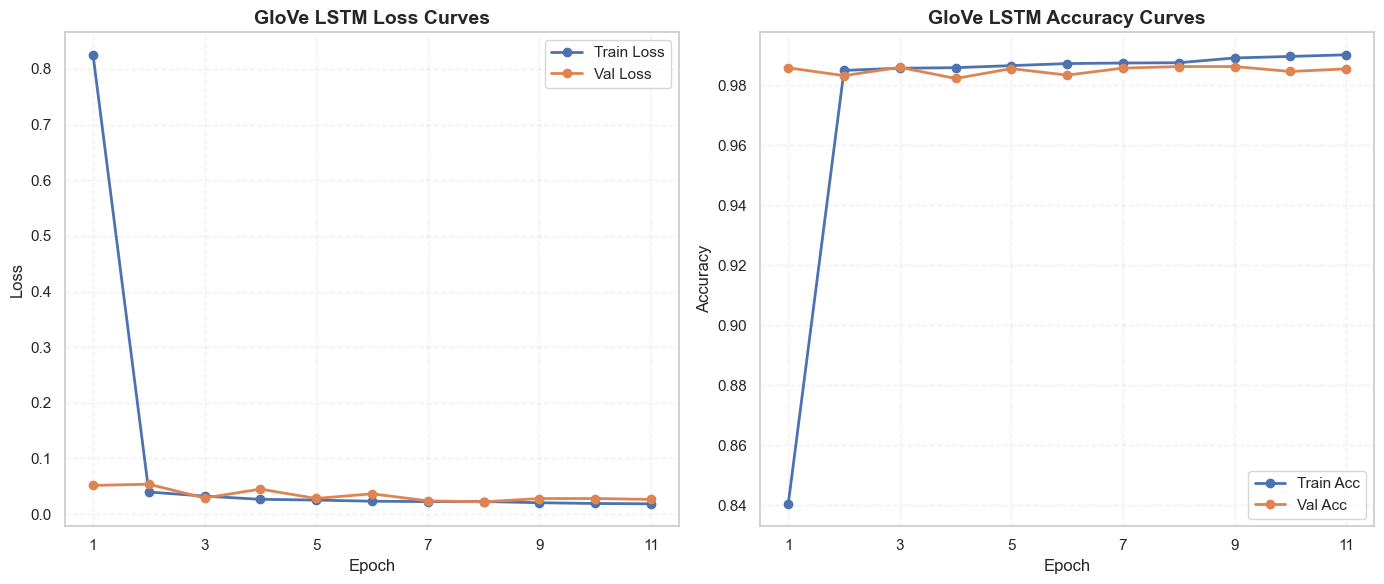

In [45]:
# Plot learning curves
plot_learning_curves(train_losses_glove, val_losses_glove, train_accs_glove, val_accs_glove, "GloVe LSTM")

In [46]:
# Evaluate on test set
model_glove.eval()
y_true_glove, y_pred_glove = [], []

with torch.no_grad():
    for X_batch, lengths_batch, y_batch in test_loader_glove:
        outputs = model_glove(X_batch, lengths_batch)
        preds = outputs.argmax(1)
        y_true_glove.extend(y_batch.numpy())
        y_pred_glove.extend(preds.numpy())

y_true_glove = np.array(y_true_glove)
y_pred_glove = np.array(y_pred_glove)

acc_glove, f1_glove, prec_glove, rec_glove = print_metrics(y_true_glove, y_pred_glove, "GloVe LSTM")

GloVe LSTM Test Results
Accuracy: 0.9851
F1 Score: 0.9850
Precision: 0.9857
Recall: 0.9851


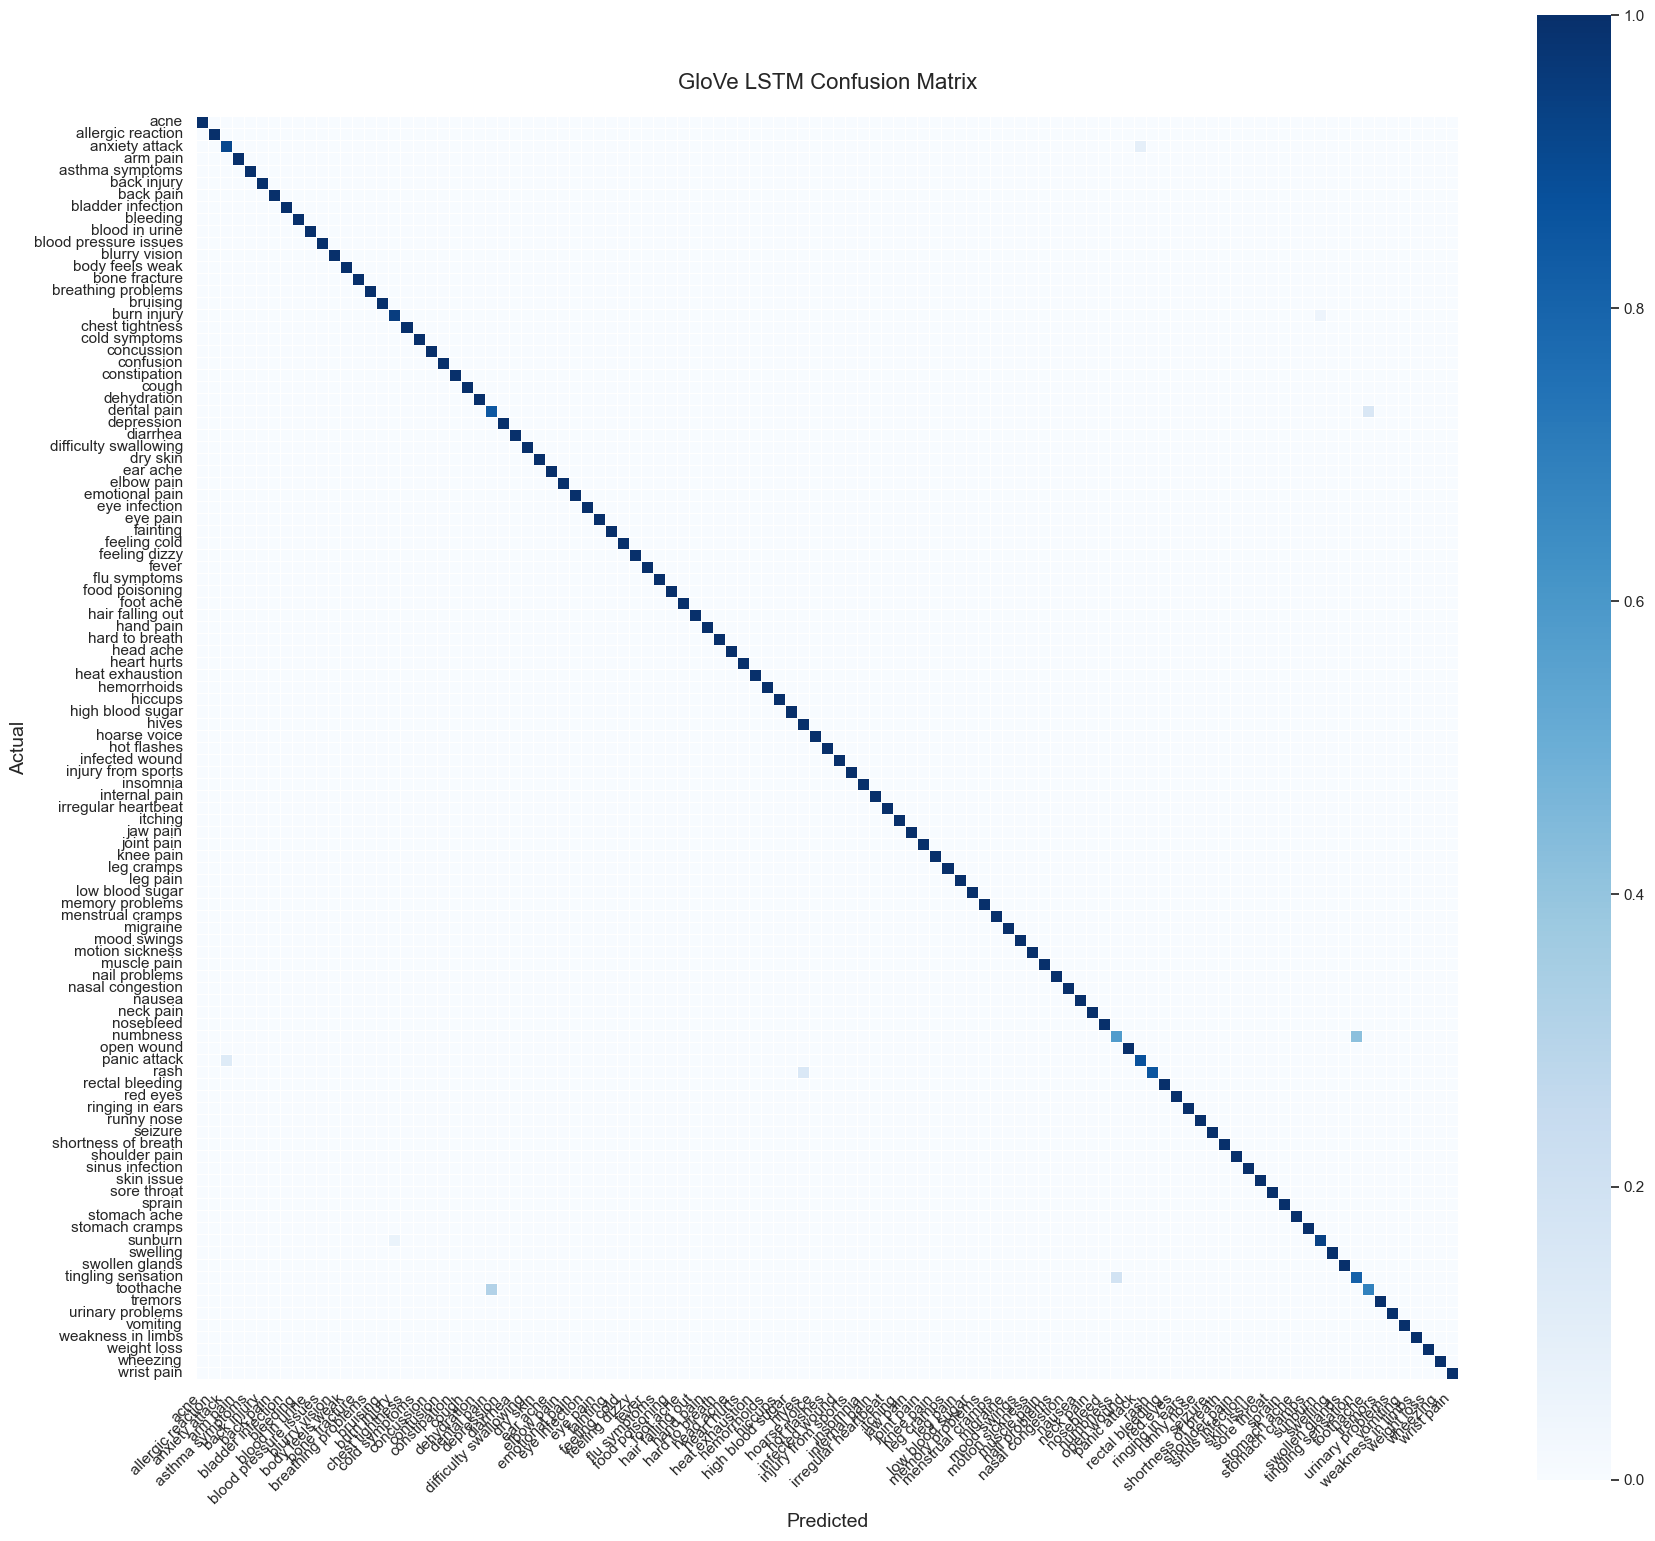

In [47]:
# Plot confusion matrix
plot_confusion_matrix(y_true_glove, y_pred_glove, le.classes_, "GloVe LSTM Confusion Matrix")

# EXPERIMENT 4: FastText + LSTM

**Purpose**: Leverage subword information for medical text.

**Key points**:
- Handles misspellings
- Understands prefixes/suffixes
- Subword modeling for medical terms

**Hyperparameters** (same as GloVe):
- Embedding dim: 100
- Hidden dim: 128
- Batch size: 32
- Max length: 50
- Learning rate: 0.001
- Epochs: 20
- FastText epochs: 20
- **Uses pack_padded_sequence**

In [48]:
embedding_dim_fasttext = 100
hidden_dim_fasttext = 128
batch_size_fasttext = 32
max_len_fasttext = 50
learning_rate_fasttext = 0.001

In [49]:
# Prepare sentences for FastText
sentences_fasttext = [text.split() for text in X_train_text]

In [50]:
# Train FastText model
fasttext_model = FastText(
    sentences=sentences_fasttext,
    vector_size=embedding_dim_fasttext,
    window=5,
    min_count=1,
    sg=1,
    epochs=20
)

print(f"FastText vocabulary size: {len(fasttext_model.wv)}")

FastText vocabulary size: 638


In [51]:
# Build embedding matrix
embedding_matrix_fasttext = np.zeros((vocab_size, embedding_dim_fasttext))
hits, misses = 0, 0

for word, idx in vocab.items():
    if word in fasttext_model.wv:
        embedding_matrix_fasttext[idx] = fasttext_model.wv[word]
        hits += 1
    else:
        embedding_matrix_fasttext[idx] = np.random.normal(scale=0.6, size=(embedding_dim_fasttext,))
        misses += 1

print(f"\nEmbedding matrix: {embedding_matrix_fasttext.shape}")
print(f"Hits: {hits}, Misses: {misses}")


Embedding matrix: (640, 100)
Hits: 640, Misses: 0


In [52]:
# FastText LSTM Model
class LSTM_FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        out = self.fc(h_n[-1])
        return out

model_fasttext = LSTM_FastText(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_fasttext,
    hidden_dim=hidden_dim_fasttext,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_fasttext
)

print(model_fasttext)

LSTM_FastText(
  (embedding): Embedding(640, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=105, bias=True)
)


In [53]:
# Training setup
criterion_fasttext = nn.CrossEntropyLoss()
optimizer_fasttext = optim.Adam(model_fasttext.parameters(), lr=learning_rate_fasttext)

train_losses_fasttext = []
val_losses_fasttext = []
train_accs_fasttext = []
val_accs_fasttext = []

In [54]:
# Training loop


for epoch in range(num_epochs):
    # Training
    model_fasttext.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for X_batch, lengths_batch, y_batch in train_loader_glove:
        optimizer_fasttext.zero_grad()
        outputs = model_fasttext(X_batch, lengths_batch)
        loss = criterion_fasttext(outputs, y_batch)
        loss.backward()
        optimizer_fasttext.step()
        
        total_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = total_loss / total
    train_acc = correct / total
    train_losses_fasttext.append(train_loss)
    train_accs_fasttext.append(train_acc)
    
    # Validation
    model_fasttext.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for X_batch, lengths_batch, y_batch in val_loader_glove:
            outputs = model_fasttext(X_batch, lengths_batch)
            loss = criterion_fasttext(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses_fasttext.append(val_loss)
    val_accs_fasttext.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/20] Train Loss: 0.8369, Train Acc: 0.8389 | Val Loss: 0.0673, Val Acc: 0.9840
Epoch [2/20] Train Loss: 0.0427, Train Acc: 0.9852 | Val Loss: 0.0314, Val Acc: 0.9868
Epoch [3/20] Train Loss: 0.0294, Train Acc: 0.9862 | Val Loss: 0.0278, Val Acc: 0.9863
Epoch [4/20] Train Loss: 0.0277, Train Acc: 0.9861 | Val Loss: 0.0230, Val Acc: 0.9864
Epoch [5/20] Train Loss: 0.0246, Train Acc: 0.9864 | Val Loss: 0.0258, Val Acc: 0.9864
Epoch [6/20] Train Loss: 0.0225, Train Acc: 0.9870 | Val Loss: 0.0242, Val Acc: 0.9857
Epoch [7/20] Train Loss: 0.0234, Train Acc: 0.9865 | Val Loss: 0.0241, Val Acc: 0.9861
Epoch [8/20] Train Loss: 0.0218, Train Acc: 0.9875 | Val Loss: 0.0237, Val Acc: 0.9861
Epoch [9/20] Train Loss: 0.0217, Train Acc: 0.9878 | Val Loss: 0.0234, Val Acc: 0.9854
Epoch [10/20] Train Loss: 0.0195, Train Acc: 0.9892 | Val Loss: 0.0230, Val Acc: 0.9874
Epoch [11/20] Train Loss: 0.0199, Train Acc: 0.9893 | Val Loss: 0.0248, Val Acc: 0.9869
Epoch [12/20] Train Loss: 0.0183, Train A

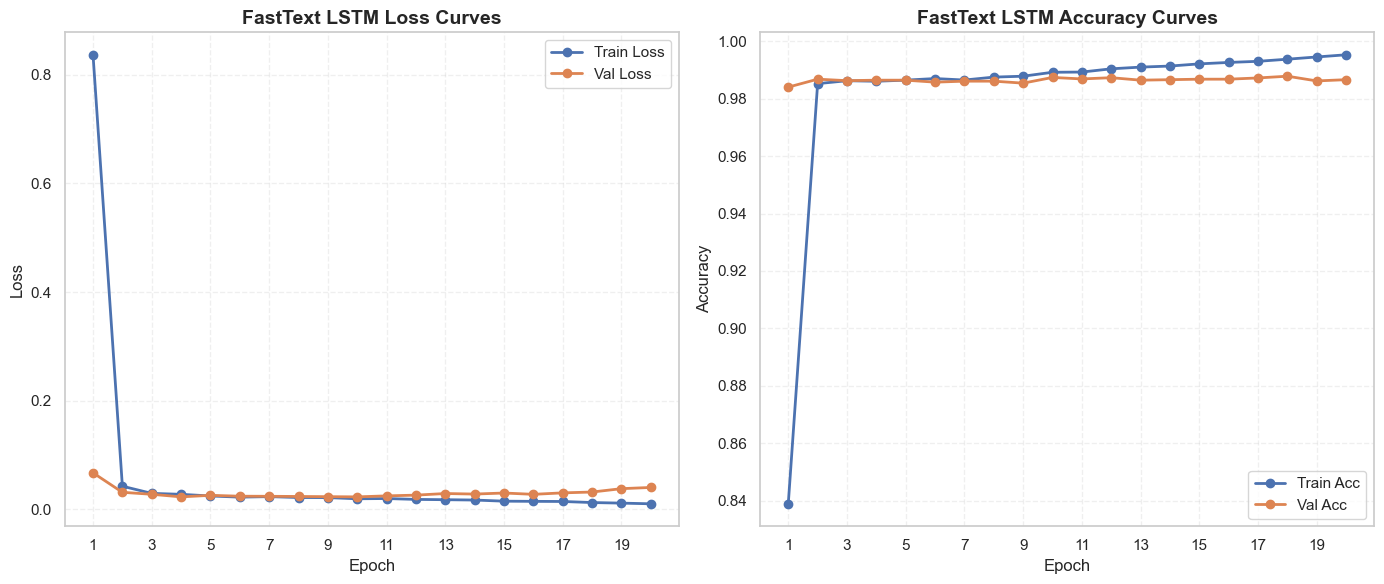

In [55]:
# Plot learning curves
plot_learning_curves(train_losses_fasttext, val_losses_fasttext, train_accs_fasttext, val_accs_fasttext, "FastText LSTM")

In [56]:
# Evaluate on test set
model_fasttext.eval()
y_true_fasttext, y_pred_fasttext = [], []

with torch.no_grad():
    for X_batch, lengths_batch, y_batch in test_loader_glove:
        outputs = model_fasttext(X_batch, lengths_batch)
        preds = outputs.argmax(1)
        y_true_fasttext.extend(y_batch.numpy())
        y_pred_fasttext.extend(preds.numpy())

y_true_fasttext = np.array(y_true_fasttext)
y_pred_fasttext = np.array(y_pred_fasttext)

acc_fasttext, f1_fasttext, prec_fasttext, rec_fasttext = print_metrics(y_true_fasttext, y_pred_fasttext, "FastText LSTM")

FastText LSTM Test Results
Accuracy: 0.9837
F1 Score: 0.9836
Precision: 0.9839
Recall: 0.9837


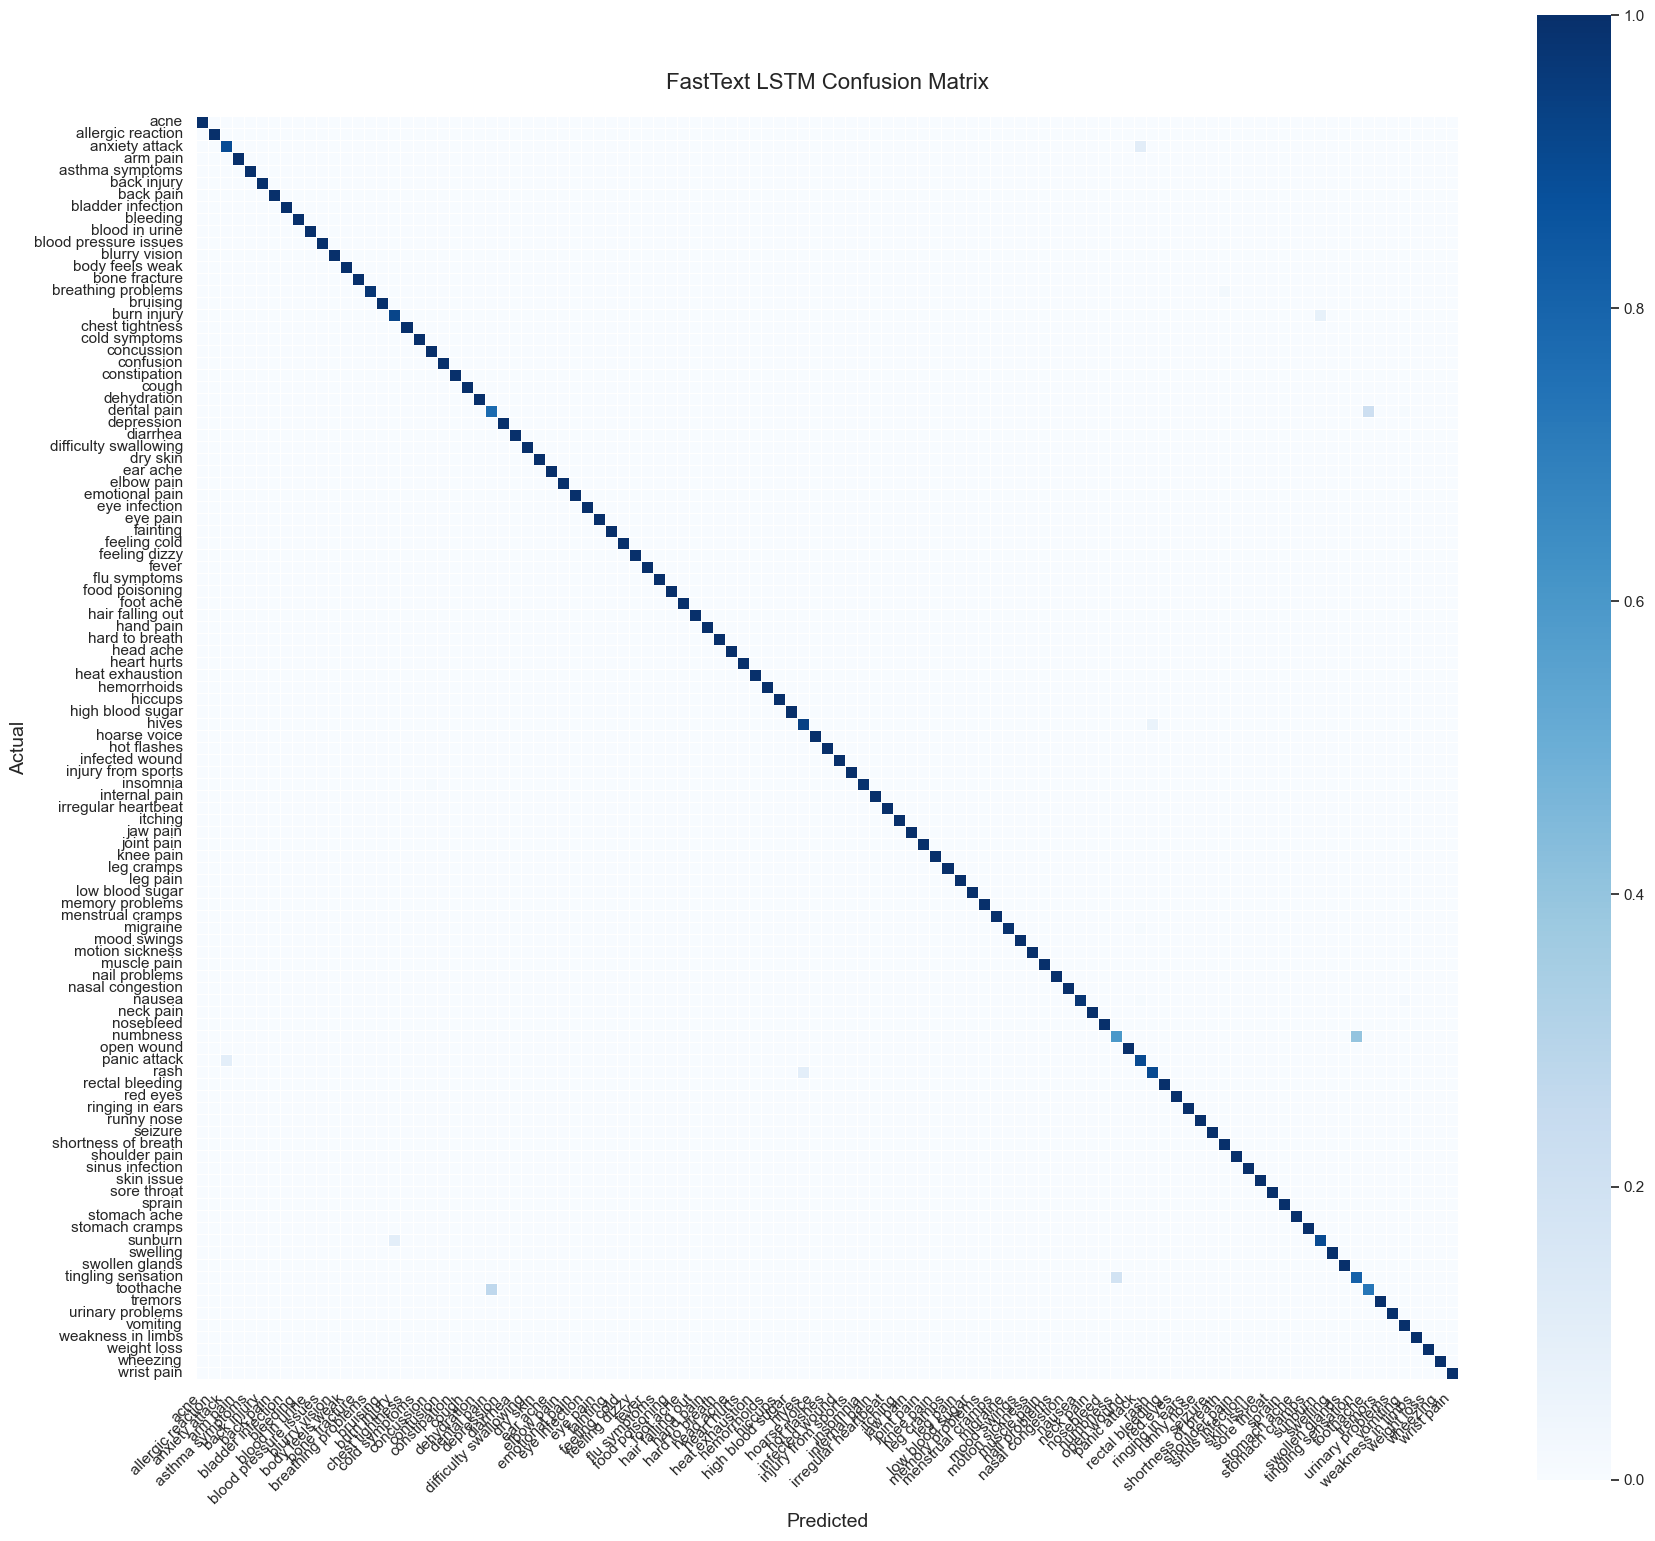

In [57]:
# Plot confusion matrix
plot_confusion_matrix(y_true_fasttext, y_pred_fasttext, le.classes_, "FastText LSTM Confusion Matrix")

---

# FINAL RESULTS COMPARISON

In [58]:
# Create results summary
results_df = pd.DataFrame({
    'Model': ['TF-IDF', 'Word2Vec LSTM', 'GloVe LSTM', 'FastText LSTM'],
    'Accuracy': [acc_tfidf, acc_w2v, acc_glove, acc_fasttext],
    'F1': [f1_tfidf, f1_w2v, f1_glove, f1_fasttext],
    'Precision': [prec_tfidf, prec_w2v, prec_glove, prec_fasttext],
    'Recall': [rec_tfidf, rec_w2v, rec_glove, rec_fasttext]
})


print("FINAL RESULTS SUMMARY")
print(results_df.to_string(index=False))


# Save results
results_df.to_csv('final_results_table.csv', index=False)
print("Results saved to 'final_results_table.csv'")

FINAL RESULTS SUMMARY
        Model  Accuracy       F1  Precision   Recall
       TF-IDF  0.984970 0.984966   0.985039 0.984969
Word2Vec LSTM  0.985661 0.986461   0.986799 0.986588
   GloVe LSTM  0.985143 0.985032   0.985669 0.985149
FastText LSTM  0.983675 0.983612   0.983896 0.983682
Results saved to 'final_results_table.csv'


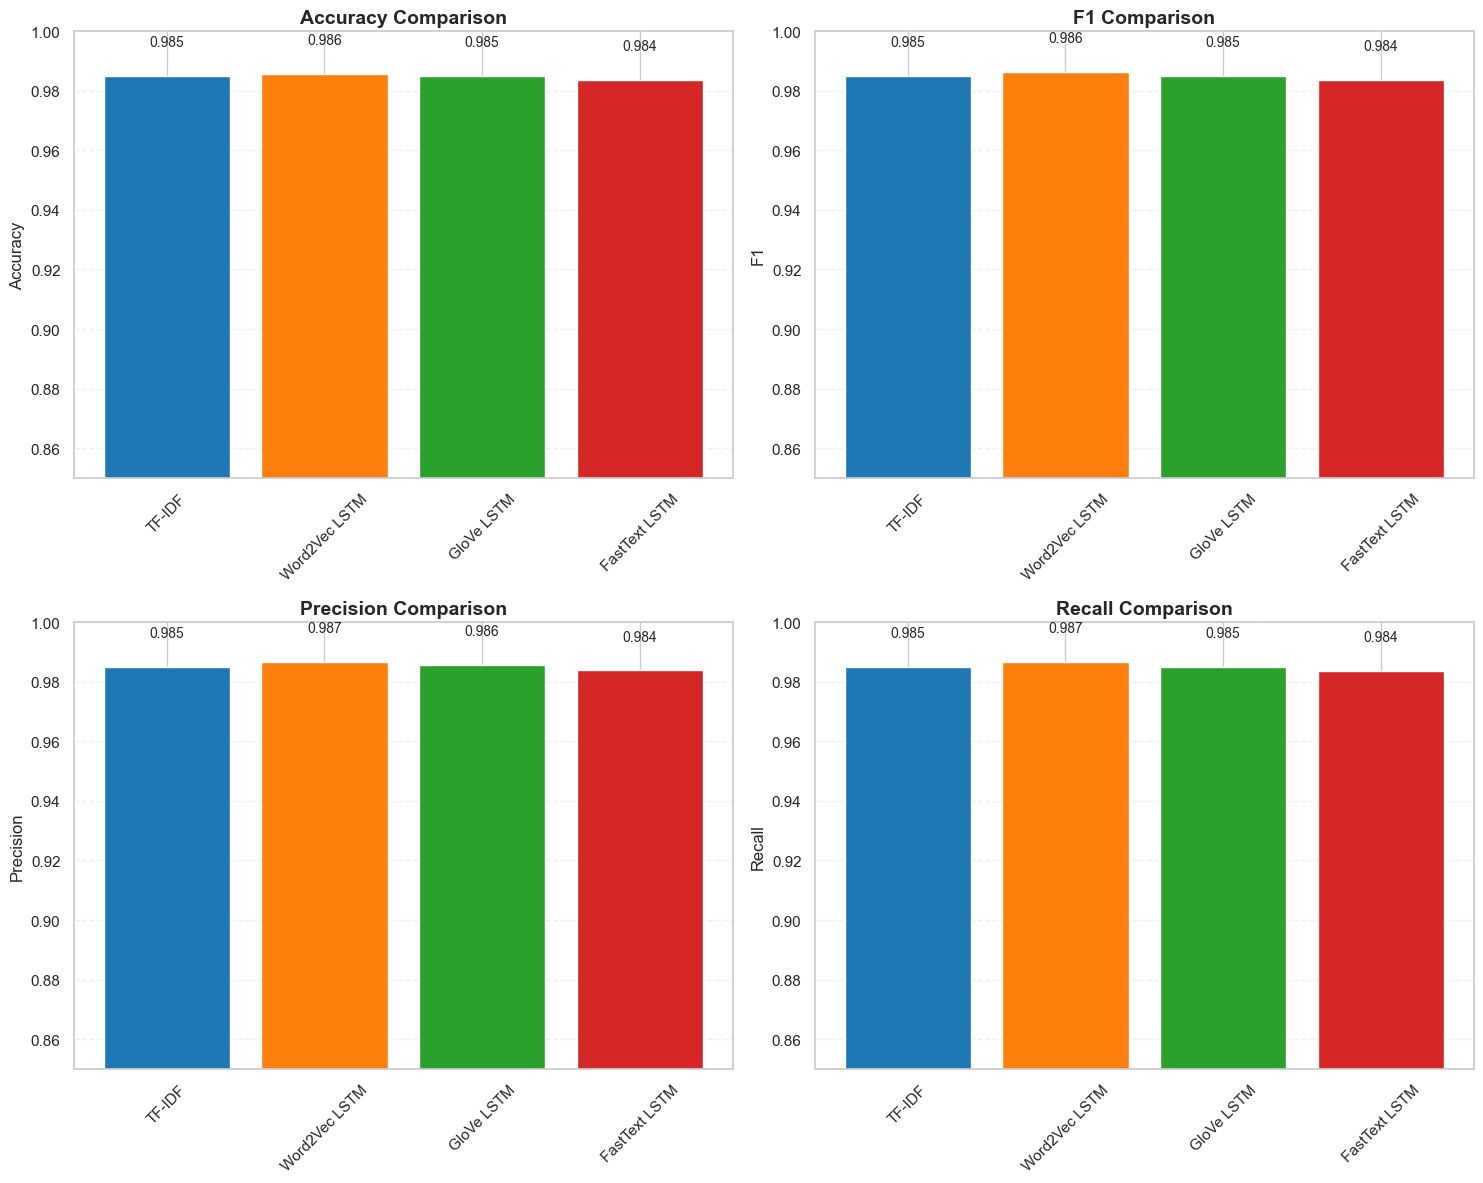

In [60]:
# Visualize results comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    ax.bar(results_df['Model'], results_df[metric], color=colors)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim([0.85, 1.0])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()